In [ ]:
using SciMLSensitivity
using DifferentialEquations
using SciMLSensitivity   # or DiffEqSensitivity if you prefer
using Zygote
using Optimisers         # for optimizer & update
using LinearAlgebra
using DifferentialEquations
using Flux
using Plots
using Optimization
using OptimizationOptimisers
using Zygote
using DataFrames

using Random
Random.seed!(1234)
println("All the nessecessary packages have been imported")

All the nessecessary packages have been imported


In [68]:

# Hodgkin-Huxley Model Parameters (Global Constants)


# Physical Constants
const Cm = 1.0        # μF/cm^2
const g_Na = 120.0    # mS/cm^2
const g_K = 36.0      # mS/cm^2
const g_L = 0.3       # mS/cm^2
const E_Na = 50.0     # mV
const E_K = -77.0     # mV
const E_L = -54.387   # mV

-54.387

In [69]:
# --- Cell 2: Known Physics & Stimulus ---

# Voltage-gated ion channel kinetics
α_n(V) = 0.01 * (V + 55) / (1 - exp(-(V + 55) / 10))
β_n(V) = 0.125 * exp(-(V + 65) / 80)
α_m(V) = 0.1 * (V + 40) / (1 - exp(-(V + 40) / 10))
β_m(V) = 4.0 * exp(-(V + 65) / 18)
α_h(V) = 0.07 * exp(-(V + 65) / 20)
β_h(V) = 1 / (1 + exp(-(V + 35) / 10))

# Steady-state & time-constant functions for the 2D model
m_inf(V) = α_m(V) / (α_m(V) + β_m(V))
h_inf(V) = α_h(V) / (α_h(V) + β_h(V))
n_inf(V) = α_n(V) / (α_n(V) + β_n(V))
tau_n(V) = 1 / (α_n(V) + β_n(V))

println("Physics of neural dynamics has been defined")



Physics of neural dynamics has been defined


In [70]:
function Stimulus(t)
    # A 1ms pulse starting at 10ms
    return(t>-10.0 && t<11.0) ? 20 : 0.0
end

println(" An extra current form neighbour to generate a pulse")

 An extra current form neighbour to generate a pulse


In [71]:
# --- Cell 3: Data Generation ---

# 2D Hodgkin-Huxley reduced model engine
function hodgkin_huxley_reduced!(du, u, p, t)
    V, n = u
    I_ext = Stimulus(t)


    # Known 2D current
    I_Na = g_Na * m_inf(V)^3 * h_inf(V) * (V - E_Na)
    I_K  = g_K  * n^4 * (V - E_K)
    I_L  = g_L * (V - E_L)
    du[1] = (I_ext - I_Na - I_K - I_L) / Cm
    du[2] = (n_inf(V) - n) / tau_n(V)
end

# Generate Data
u0_true = [-65.0, n_inf(-65.0)]
tspan = (0.0, 50.0)
prob_true = ODEProblem(hodgkin_huxley_reduced!, u0_true, tspan)
sol_true = solve(prob_true, Rodas5P(), saveat=0.5)

# Extract and structure the training data
data_V = sol_true[1, :]
t_train = sol_true.t

# (Optional) Verify data shape and content
df = DataFrame(t=t_train, V=data_V )
println("Generated Training Data:")
display(first(df, 5))

Row,t,V
,Float64,Float64
1,0.0,-65.0
2,0.5,-54.674
3,1.0,-30.723
4,1.5,-22.2061
5,2.0,-31.3453


Generated Training Data:


In [72]:
U = Chain(
    Dense(1,15, tanh,init = Flux.glorot_uniform),
    # Dense(15,30,tanh,init = Flux.glorot_uniform),
    Dense(15,1,init=Flux.glorot_uniform)
)

Chain(
  Dense(1 => 15, tanh),                 # 30 parameters
  Dense(15 => 1),                       # 16 parameters
)                   # Total: 4 arrays, 46 parameters, 392 bytes.

In [73]:
# Extract the trainable parameters (p_nn) and the re-structuring function (re)
p_nn, re = Flux.destructure(U)
println("Recruit Constructed. Parameters: ", length(p_nn))


Recruit Constructed. Parameters: 46


## The hybrid UDE

In [74]:


# Define the UDE function with the embedded neural network
function ude_dynamics!(du, u, p, t)
    V, n = u
    # p --> p_nn neural network parameters
    # Neural network component to learn the unknown current
    # we will normalize V roughly ( divide by 100) to keep inputs clean for the NN

    nn_input = V / 100.0
    # We divide V by 100.0 to keep inputs small for the Neural Network
    # Example: -65mV becomes -0.65

    nn_I_Na = re(p)([nn_input])[1]
    # Known physics components
    I_ext = Stimulus(t)
    I_K  = g_K  * n^4 * (V - E_K)
    I_L  = g_L * (V - E_L)
    
    # The hybrid dynamics equation
    du[1] = (I_ext + nn_I_Na - I_K - I_L) / Cm
    du[2] = (n_inf(V) - n) / tau_n(V)
end
println("Hybrid Engine Assembled.")

Hybrid Engine Assembled.


In [75]:
# ---- Stable predict function using BacksolveAdjoint and Float64 inputs ----



prob_nn = ODEProblem(ude_dynamics!,u0_true,tspan , p_nn)
function predict_ude(p)
    # build problem with the current flattened NN params


    _prob=remake(prob_nn,p=p)
    
    
    solve(_prob, Rodas5P(), saveat=t_train, 
          sensealg=InterpolatingAdjoint(autojacvec=ZygoteVJP()))
end


# ---- Loss function (keep as Float64) ----
function loss(p)
    pred = predict_ude(p)
    if pred.retcode != :Success
        return 1e6
    end
    pred_V = pred[1, :]
    loss_val = sum(abs2, pred_V .- data_V)
    return loss_val
end

println("Objective Functions Defined.")

Objective Functions Defined.


In [76]:

losses=[]
callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Iteration: $(length(losses)) | Loss: $l")
    end
    return false
end

#47 (generic function with 1 method)

In [80]:

# Define the optimization problem
optf = Optimization.OptimizationFunction((x, p) -> loss(x), Optimization.AutoZygote())
optprob = Optimization.OptimizationProblem(optf, p_nn)

# Execute the training mission
println("Commencing Training...")
# We use a lower learning rate for stability and more iterations.
# This is a full-scale training run. It may take a few minutes.
res = Optimization.solve(optprob, OptimizationOptimisers.Adam(0.02), 
                         callback=callback, maxiters=5000)

println("--- TRAINING COMPLETE ---")
println("Training Complete. Final Loss: ", res.objective)

Commencing Training...
Iteration: 1050 | Loss: 2664.6359799692123
Iteration: 1100 | Loss: 2380.02732638078
Iteration: 1150 | Loss: 1692.0129685655813
Iteration: 1200 | Loss: 1523.6692730650734
Iteration: 1250 | Loss: 1256.5893983533892
Iteration: 1300 | Loss: 926.6116137108296
Iteration: 1350 | Loss: 726.4385148712884
Iteration: 1400 | Loss: 659.0594994958063
Iteration: 1450 | Loss: 622.4401819110761
Iteration: 1500 | Loss: 619.4790857104351
Iteration: 1550 | Loss: 588.6737898474523
Iteration: 1600 | Loss: 574.5920158150489
Iteration: 1650 | Loss: 560.3891997069217
Iteration: 1700 | Loss: 546.571485841467
Iteration: 1750 | Loss: 533.0086715028173
Iteration: 1800 | Loss: 521.8530913177848
Iteration: 1850 | Loss: 506.32296224134456
Iteration: 1900 | Loss: 522.836754986452
Iteration: 1950 | Loss: 463.4739414136897
Iteration: 2000 | Loss: 368.0476492564954
Iteration: 2050 | Loss: 121.47380953174306
Iteration: 2100 | Loss: 73.74004332987073
Iteration: 2150 | Loss: 46.46935838873958
Iteratio

In [87]:
using OptimizationOptimJL # Essential for L-BFGS/BFGS

In [94]:

# 2. Set up the problem again using Adam's final result (res.u)
# Note: We stick with the same 'optf' we defined earlier.
optprob2 = Optimization.OptimizationProblem(optf, res.u)

losses_phase2 = []

callback_phase2 = function (p, l)
    push!(losses_phase2, l)
    if length(losses_phase2) % 10 == 0 # Log more frequently
        println("Phase II Iter: $(length(losses_phase2)) | Loss: $l")
    end
    return false
end

println("--- ATTEMPTING PHASE II: BFGS (Heavy Tank) ---")

# STRATEGY CHANGE:
# 1. Use BFGS() instead of LBFGS() - it is more robust.
# 2. Use linesearch=BackTracking() - helps it step carefully over rough terrain.
try
    res_final = Optimization.solve(optprob2, OptimizationOptimJL.BFGS(),
                                   callback=callback_phase2,
                                   maxiters=500)
                                   
    println("--- MISSION SUCCESS ---")
    println("Final Refined Loss: ", res_final.objective)
    
    # Update the plotting with the new data
    final_solution_params = res_final.u

catch e
    println("BFGS Stalled/Failed. Fallback to parameters from Adam.")
    println("Error: ", e)
    final_solution_params = res.u
end

--- ATTEMPTING PHASE II: BFGS (Heavy Tank) ---
Phase II Iter: 10 | Loss: 3.0498812
Phase II Iter: 20 | Loss: 0.922778
Phase II Iter: 30 | Loss: 0.1280644
--- MISSION SUCCESS ---
Final Refined Loss: 0.1280644


46-element Vector{Float32}:
   7.452164
   9.82162
   9.879741
   0.39945436
  -1.3977616
  -0.05768034
  -2.7304316
   6.0047154
  -4.2428885
  -9.282789
   ⋮
  -8.84703
  -1.7384942
  -8.8631935
 -13.743014
  17.937546
  -6.677028
  -7.2081065
   7.449376
   1.9413325

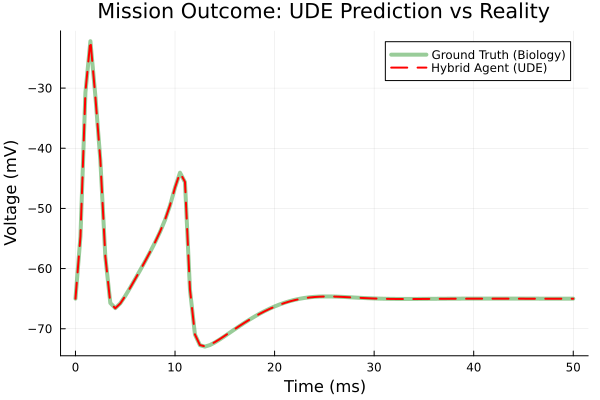

In [101]:
# Use the final parameters from the sniper mission (res_final.u)
final_sol = predict_ude(res_final.u)

p2 = plot(t_train, data_V, 
     label="Ground Truth (Biology)", lw=4, color=:green, alpha=0.4)

plot!(p2, final_sol.t, final_sol[1, :], 
      label="Hybrid Agent (UDE)", lw=2, color=:red, linestyle=:dash)

title!(p2, "Mission Outcome: UDE Prediction vs Reality")
xlabel!("Time (ms)")
ylabel!("Voltage (mV)")

display(p2)

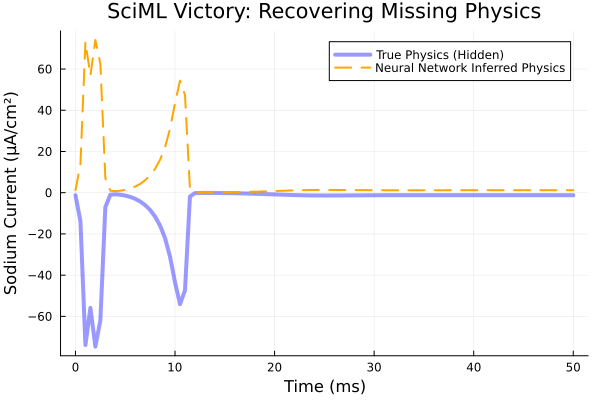

In [102]:
# 1. Calculate the TRUE Sodium Current from the biology (Analytic)
# We use the data we generated way back in step 3
I_Na_true = [g_Na * m_inf(v)^3 * h_inf(v) * (v - E_Na) for v in data_V]

# 2. Calculate what our Neural Network THINKS the current is
# We pass the voltage data through the trained network 're(res_final.u)'
nn_currents = [re(res_final.u)([v/100])[1] for v in data_V]

# 3. Compare them
p3 = plot(t_train, I_Na_true, 
     label="True Physics (Hidden)", lw=4, color=:blue, alpha=0.4)

plot!(p3, t_train, nn_currents, 
      label="Neural Network Inferred Physics", lw=2, color=:orange, linestyle=:dash)

title!(p3, "SciML Victory: Recovering Missing Physics")
xlabel!("Time (ms)")
ylabel!("Sodium Current (μA/cm²)")

display(p3)

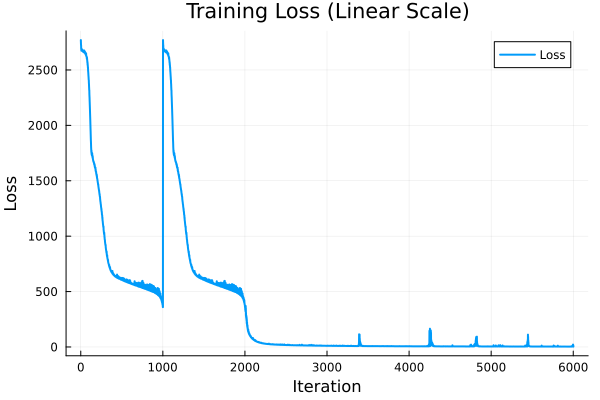

In [95]:
plot(losses,
     xlabel="Iteration",
     ylabel="Loss",
     title="Training Loss (Linear Scale)",
     label="Loss",
     lw=2)


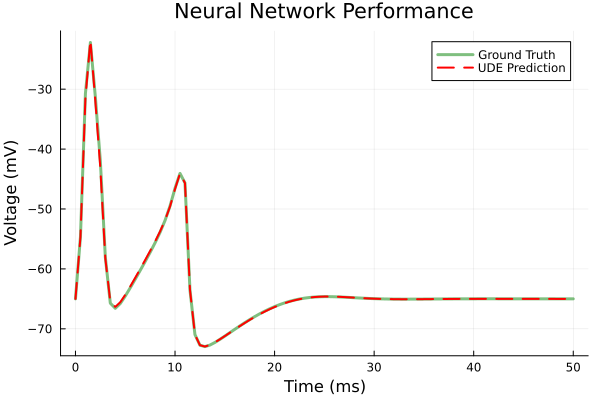

In [96]:
# 2. Visualizing the Recruit vs The Master
# Run a prediction with the TRAINED parameters (res.u)
final_sol = predict_ude(res.u)

p2 = plot(t_train, data_V, label="Ground Truth", lw=3, alpha=0.5, color=:green)
plot!(p2, final_sol.t, final_sol[1,:], label="UDE Prediction", lw=2, color=:red, linestyle=:dash)
title!(p2, "Neural Network Performance")
xlabel!("Time (ms)")
ylabel!("Voltage (mV)")
display(p2)

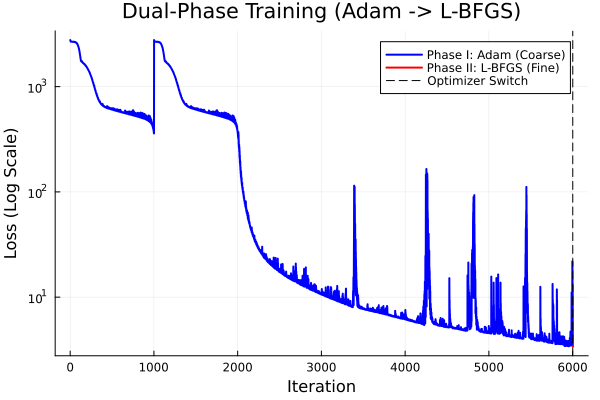

In [97]:
# Combined Plotting
total_iterations = 1:(length(losses_adam) + length(losses_lbfgs))

# Setup the canvas
p_combined = plot(title="Dual-Phase Training (Adam -> L-BFGS)", 
                  xlabel="Iteration", ylabel="Loss (Log Scale)", yaxis=:log)

# Plot Phase 1: Adam (Blue)
plot!(p_combined, 1:length(losses_adam), losses_adam, 
      label="Phase I: Adam (Coarse)", color=:blue, lw=2)

# Plot Phase 2: L-BFGS (Red)
# We shift the x-axis so it starts exactly where Adam ended
range_phase2 = (length(losses_adam)+1):length(total_iterations)
plot!(p_combined, range_phase2, losses_lbfgs, 
      label="Phase II: L-BFGS (Fine)", color=:red, lw=2)

# Add a vertical line to mark the hand-off
vline!(p_combined, [length(losses_adam)], label="Optimizer Switch", color=:black, linestyle=:dash)

display(p_combined)